In [33]:
# Code to get central vs sidelobe flux for different 'phase differences'
# Import our packages
import dLuxToliman as dlT
import dLux as dl
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax.numpy as np

In [34]:
# Gonna do just airy disk toliman
wf_npixels = 2048 # highest resolution without crashing
diameter = 0.125
period = diameter/64
difference = np.pi

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)
gratingLayer = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,False)
# adding the diffractive pupil
pupilLayer = dlT.TolimanPupilLayer(wf_npixels)
layers = [
    (
        'aperture',
        apertureLayer
    ),
    (
        'grating',
        gratingLayer
    ),
    (
        'pupil',
        pupilLayer
    )
]

In [41]:
psf_npixels = 32
pixel_scale = 1 
oversample = 8 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)
wavelengths = np.array([585e-9])

flux = 1
source = dl.PointSource(wavelengths, np.zeros(2), flux)

# sidelobe layer for bottom left corner
sidelobeShiftLayer = dlT.SidelobeShiftLayer(wf_npixels, diameter, period, wavelengths[0], pixel_scale, oversample)

sidelobeLayers = [
    (
        'sidelobeShift',
        sidelobeShiftLayer
    ),
    (
        'aperture',
        apertureLayer
    ),
    (
        'grating',
        gratingLayer
    )
]

opticsLobe = dl.AngularOpticalSystem(wf_npixels,diameter,sidelobeLayers,psf_npixels,pixel_scale,oversample)

In [42]:
psf = optics.model(source)
psfLobe = opticsLobe.model(source)

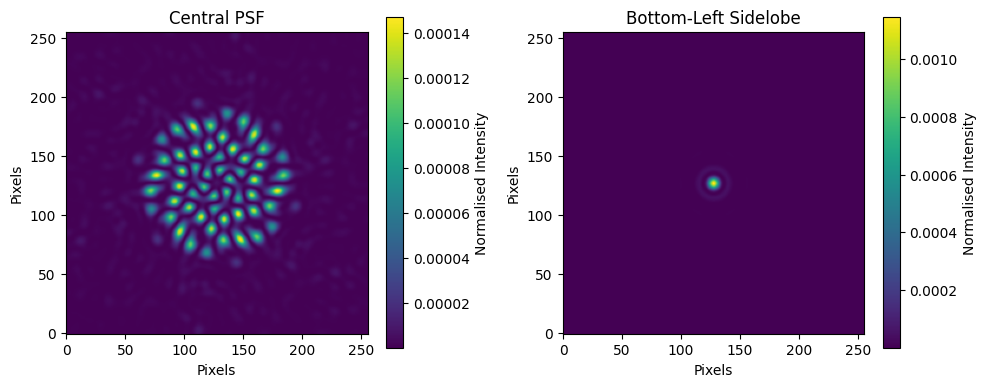

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(psf,origin='lower')
plt.title('Central PSF')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(label='Normalised Intensity')

plt.subplot(1,2,2)
plt.imshow(psfLobe,origin='lower')
plt.title('Bottom-Left Sidelobe')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.colorbar(label='Normalised Intensity')

plt.tight_layout()
plt.show()

In [70]:
# Cool. Let's let it run for 10 values between 0.1pi and 1 pi
# Gonna do just airy disk toliman
wf_npixels = 1024 # lower res 
diameter = 0.125
period = diameter/64 # longer period

psf_npixels = 64
pixel_scale = 1 
oversample = 8 # high level oversample

wavelengths = np.array([585e-9])
flux = 1
source = dl.PointSource(wavelengths, np.zeros(2), flux)

differences = np.pi * np.arange(0, 2.6, 0.1)
centre_fluxes = np.zeros_like(differences)
sidelobe_fluxes = np.zeros_like(differences)

In [71]:
for idx, difference in enumerate(differences):
    apertureLayer = dlT.TolimanApertureLayer(wf_npixels)
    gratingLayer = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,False)
    gratingLayerInversion = dlT.PhaseGratingLayer(wf_npixels,diameter,period,difference,True)
    # adding the diffractive pupil
    #pupilLayer = dlT.TolimanPupilLayer(wf_npixels)

    layers = [
        (
            'aperture',
            apertureLayer
        ),
        (
            'grating',
            gratingLayerInversion
        ),
        (
            'pupil',
            pupilLayer
        )
    ]

    optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,pixel_scale,oversample)
    # sidelobe layer for bottom left corner
    sidelobeShiftLayer = dlT.SidelobeShiftLayer(wf_npixels, diameter, period, wavelengths[0], pixel_scale, oversample)

    sidelobeLayers = [
        (
            'sidelobeShift',
            sidelobeShiftLayer
        ),
        (
            'aperture',
            apertureLayer
        ),
        (
            'grating',
            gratingLayer
        )
    ]

    opticsLobe = dl.AngularOpticalSystem(wf_npixels,diameter,sidelobeLayers,psf_npixels,pixel_scale,oversample)

    psf = optics.model(source)
    psfLobe = opticsLobe.model(source)

    # saving the fluxes
    centre_fluxes = centre_fluxes.at[idx].set(np.sum(psf))
    
    sidelobe_fluxes = sidelobe_fluxes.at[idx].set(np.sum(psfLobe))

    print(centre_fluxes[idx], sidelobe_fluxes[idx])

0.9233765 0.0005084784
0.9176995 0.0020305521
0.9008515 0.006500332
0.8733732 0.013671636
0.83613676 0.023150438
0.7903065 0.034418765
0.73728585 0.046864826
0.6786531 0.05981974
0.6160917 0.07259601
0.55132085 0.084526725
0.48602086 0.095003374
0.42176965 0.10350812
0.3599832 0.10964134
0.30187017 0.1131397
0.24839681 0.11388687
0.20026699 0.111913875
0.1579173 0.10739146
0.12152376 0.10061384
0.09102379 0.09197564
0.06614557 0.081944406
0.04644752 0.071028955
0.031361558 0.05974791
0.020238882 0.048599266
0.01239484 0.038031865
0.0071504004 0.028423714
0.0038680932 0.02006445


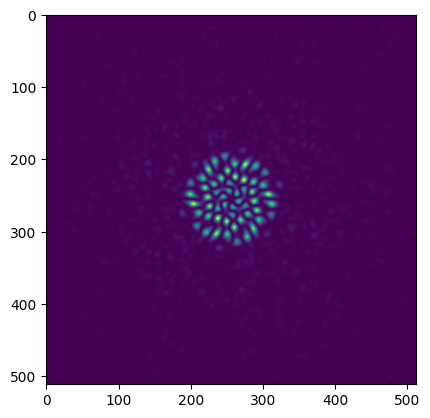

In [72]:
plt.imshow(optics.model(source))
plt.show()

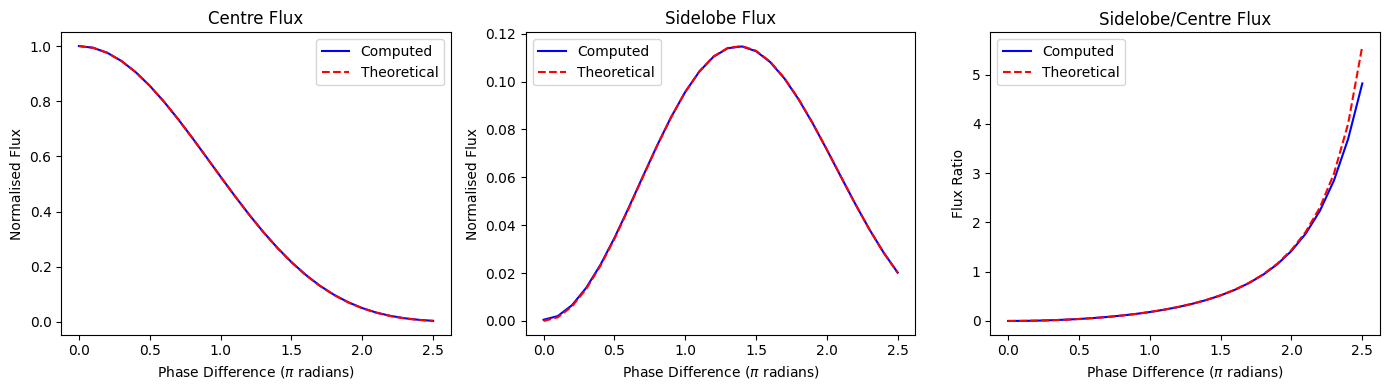

In [ ]:
# from week 11 new stuff
from scipy.special import jv

norm_factor = 1/centre_fluxes[0]
norm_factor_lobe = (jv(0, differences[10]/4)**2 *  jv(1, differences[10]/4)**2)/sidelobe_fluxes[10]

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.title('Centre Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Normalised Flux')
plt.plot(differences/np.pi, centre_fluxes*norm_factor, label='Computed', color='blue')
plt.plot(differences/np.pi, jv(0, differences/4)**4 , label='Theoretical', linestyle='--', color='red')
plt.legend()

plt.subplot(1,3,2)
plt.title('Sidelobe Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Normalised Flux')
plt.plot(differences/np.pi,sidelobe_fluxes*norm_factor_lobe, label = 'Computed', color='blue')
plt.plot(differences/np.pi, (jv(0, differences/4)**2 * jv(1, differences/4)**2), label =  'Theoretical', linestyle='--',color='red')
plt.legend()

plt.subplot(1,3,3)
plt.title('Sidelobe/Centre Flux')
plt.xlabel(r'Phase Difference ($\pi$ radians)')
plt.ylabel('Flux Ratio')
plt.plot(differences/np.pi,sidelobe_fluxes*norm_factor_lobe/(centre_fluxes*norm_factor),label='Computed',color='blue')
#plt.plot(x_fit, y_fit,label='Quartic fit (no const./linear terms)',linestyle=':')

plt.plot(differences/np.pi, jv(1, differences/4)**2/jv(0, differences/4)**2,label='Theoretical',linestyle='--',color='red')

plt.legend()

plt.tight_layout()
#plt.savefig('better_fluxes_improved.pdf')
plt.show()